In [1]:
import numpy as np
from random import randint
import torch
import torch.nn as nn

NSAMPLE = 10
MAX_PIX_NUM = 100
XMAX = 1024.
YMAX = 512.

def read_datafile(datafile="head_input_230MeV_cs.txt"):
    l = []
    i = 0

    with open(datafile, "r") as f:
        while True:
            line = f.readline()
            if len(line) == 0:
                break; # eof
            while len(line.strip()) == 0:
                line = f.readline() # skip blank lines
            lf = line.split()
            gtruth = np.array([float(lf[2])/XMAX,float(lf[3])/YMAX,lf[5]],dtype=float)
            inp = np.vstack(([float(x)/XMAX for x in lf[7::2]],[float(y)/YMAX for y in lf[8::2]])).ravel(order='F')
#            inp = np.array(lf[7:],dtype=int)
            if len(inp)>0:
                l.append([gtruth,inp])
                i += 1
    return l

print("Reading data file ...")
l = read_datafile()
print("Done...")

def trainLoader(batch_size):
    x = [None] * batch_size
    y = [None] * batch_size
    for ib in range(batch_size):
        sel = [randint(0,len(l)-1) for p in range(NSAMPLE)]
        
        try:
            t0 = np.concatenate([l[i][1] for i in sel])
        except IndexError:
            print('sel = ',sel)
            return()
        while(len(t0) > 2*MAX_PIX_NUM):
            sel = [randint(0,len(l)-1) for p in range(NSAMPLE)]
            t0 = np.concatenate([l[i][1] for i in sel])
        t = np.unique(XMAX*t0[0::2]+t0[1::2])
        ind = np.argsort(t)
        x[ib] = np.zeros(2*MAX_PIX_NUM,dtype=float)
#        x[ib] = 1e-10*np.ones(2*MAX_PIX_NUM,dtype=float)
        x[ib][:2*len(t)] = np.concatenate([[int(t[i])/XMAX, t[i]-int(t[i])] for i in ind])

        t1 = [XMAX*l[i][0][0]+l[i][0][1] for i in sel]
        ind = np.argsort(t1)
        y[ib] = np.concatenate([l[sel[i]][0] for i in ind])
        
    return torch.FloatTensor(x), torch.FloatTensor(y)



Reading data file ...
Done...


Joshua Santana put some track nn to https://project-gitlab.ztt.hs-worms.de/pct/pct/-/blob/b01a92ea411c514f70bd6d8f3b31421bdf7578a4/water_equivalent_path_length/src/ptt_cnn.py
 (needs ztt password)
 
https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

VAE: input 2x100 numbers (100 pairs of X,Y, padded with zeroes, order in X first, Y second direction)
     output 3x10 numbers 10 triples of (X,Y,Edep)
     
Encoder: 2x100 -> 32 RELU -> 2 x 10 (mean, var_log) -> z = mean + var * N(0,1)
Decode:  2 x 10 -> 32 RELU -> 3 x 10 SIGMOID

There is also an Encoder2 taking the "real" hits and reconstructing them, used only during training:

Encoder (detector response) \
                              --> hidden space --> z  --> Decoder
Encoder2 (hits)             /

ELBO (Evidence lower bound): recunstruction loss + KL divergence term with the distance of Gauss parameters of Encoder and Encoder2 mapping into the hidden space
ELBO = E_q ( log q(z|x) - log p(z) )   <- KL term
       - E_q log( p(x|z) )             <- reconstruction loss
"q" is the real distribution from Encoder2, p is the approximative from Encoder

#BCE_loss with KLD containing log_var and mean

In [2]:
#import torch
#import torch.nn as nn
#import numpy as np

cuda = True
#DEVICE = torch.device("cuda" if cuda else "cpu")
DEVICE = torch.device("cpu")
print("DEVICE is {}".format(DEVICE))

batch_size = 64

x_dim  = 2*100
hidden_dim = 32
latent_dim = 10 # twice: mean / log_var
output_dim = 3*10 # (X,Y,Edep) for 10 hits

lr = 1e-3

epochs = 20

DEVICE is cpu


In [4]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        self.training = True
        
    def forward(self, x):
        h_       = torch.relu(self.FC_input(x))
        mean     = self.FC_mean(h_)
#        print('mean:',mean)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
#        print('log_var:',log_var)
                                                       #             (i.e., parateters of simple tractable normal distribution "q")
        var      = torch.exp(0.5*log_var)              # takes exponential function
#        print('var:',var)
        z        = self.reparameterization(mean, var)
        
        return z, mean, log_var
       
    def reparameterization(self, mean, var,):
        epsilon = torch.rand_like(var).to(DEVICE)        # sampling epsilon
        
        z = mean + var*epsilon                          # reparameterization trick
        
        return z

class Encoder2(nn.Module):
    
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.FC_input = nn.Linear(output_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        self.training = True
        
    def forward(self, x):
        h_       = torch.relu(self.FC_input(x))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q")
        var      = torch.exp(0.5*log_var)              # takes exponential function
        z        = self.reparameterization(mean, var)
        
        return z, mean, log_var
       
    def reparameterization(self, mean, var,):
        epsilon = torch.rand_like(var).to(DEVICE)        # sampling epsilon
        
        z = mean + var*epsilon                          # reparameterization trick
        
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h     = torch.relu(self.FC_hidden(x))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
    
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
                
    def forward(self, x):
        z, mean, log_var = self.Encoder(x)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

class Model2(nn.Module):
    def __init__(self, Encoder, Encoder2, Decoder):
        super(Model2, self).__init__()
        self.Encoder = Encoder
        self.Encoder2 = Encoder2
        self.Decoder = Decoder
                
    def forward(self, x):
        z2, mean2, log_var2 = self.Encoder2(x[0])
        z, mean, log_var = self.Encoder(x[1])
        x_hat            = self.Decoder(z2)
        
        return x_hat, mean, log_var, mean2, log_var2

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
encoder2 = Encoder(input_dim=output_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = output_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
model2= Model2(Encoder=encoder, Encoder2=encoder2, Decoder=decoder).to(DEVICE)

from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(y, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, y, reduction='sum')
#    reproduction_loss = nn.MSELoss()
    KLD = 0.
#    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

#    return reproduction_loss(x_hat, y) + KLD    
    return reproduction_loss + KLD

EPS = 1e-10
def loss_function2(y,x_hat, mean, log_var, mean2, log_var2):
    reproduction_loss = torch.sum(y-x_hat+x_hat*torch.log((x_hat+EPS)/(y+EPS)))  # something to regularize y=0 ...
    var = torch.exp(0.5*log_var)
    var2 = torch.exp(0.5*log_var2)
    dv = var/var2
    KLD = torch.sum((mean-mean2)**2*0.5/var**2 + torch.log(dv) + 0.5/dv**2-0.5)

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

In [5]:
#torch.autograd.set_detect_anomaly(True)

print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
#    for batch_idx in range(len(l)//batch_size):
    for batch_idx in range(1000):
        t = trainLoader(batch_size)
        x = t[0]
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
#        x_hat, mean, log_var, mean2, log_var2 = model(x)
        
#        x_hat[x_hat>1] = 1  # !!! Cross-entropy safekeeping
        x_hat = torch.clamp(x_hat,0,1)
        
        loss = loss_function(t[1], x_hat, mean, log_var)  
#        loss = loss_function2(t[1], x_hat, mean, log_var, mean2, log_var2)  
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete 	Average Loss:  14.235639633239808
	Epoch 2 complete 	Average Loss:  13.574977927260452
	Epoch 3 complete 	Average Loss:  13.460250438273967
	Epoch 4 complete 	Average Loss:  13.38987782338002
	Epoch 5 complete 	Average Loss:  13.354362375146753
	Epoch 6 complete 	Average Loss:  13.336495178955811
	Epoch 7 complete 	Average Loss:  13.30746279345141
	Epoch 8 complete 	Average Loss:  13.272333176644358
	Epoch 9 complete 	Average Loss:  13.262777762847382
	Epoch 10 complete 	Average Loss:  13.251915946975723
	Epoch 11 complete 	Average Loss:  13.231990507773093
	Epoch 12 complete 	Average Loss:  13.237367405667081
	Epoch 13 complete 	Average Loss:  13.226389659656299
	Epoch 14 complete 	Average Loss:  13.223541150937924
	Epoch 15 complete 	Average Loss:  13.214199236086062
	Epoch 16 complete 	Average Loss:  13.209313124388427
	Epoch 17 complete 	Average Loss:  13.210652763779098
	Epoch 18 complete 	Average Loss:  13.20108912489913
	Epoch 19 complete

In [ ]:
## TEST block, do NOT run

t = trainLoader(batch_size)
#encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
#decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = output_dim)
#model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
#model.forward(t[0])
#t[0]
#encoder.forward(t[0])[0]
decoder.forward(encoder.forward(t[0])[0])

In [16]:
with torch.no_grad():
    t = trainLoader(batch_size)
    x = t[0]
    x = x.view(batch_size, x_dim)
    x = x.to(DEVICE)
    z, mean, log_var = encoder(x)
    x_hat            = decoder(z)


In [247]:
## TEST block, do NOT run

model.eval()
with torch.no_grad():
    t = trainLoader(batch_size)
    x = t[0]
    x = x.view(batch_size, x_dim)
    x = x.to(DEVICE)

    x_hat, _, _ = model(x)


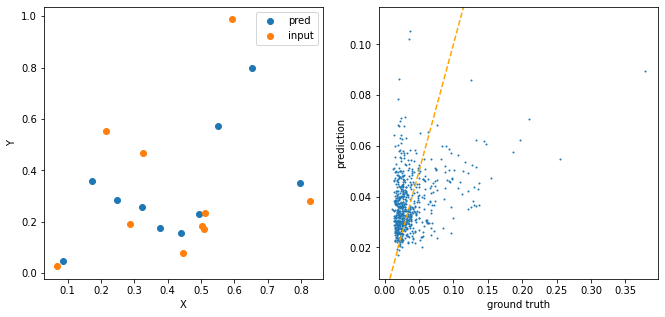

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(11,5))

pred = x_hat[0]
ax[0].scatter([pred[3*i] for i in range(10)],[pred[3*i+1] for i in range(10)],label='pred')
gt = t[1][0]
ax[0].scatter([gt[3*i] for i in range(10)],[gt[3*i+1] for i in range(10)],label='input')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].legend()

ax[1].scatter(t[1][:,2::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0],x_hat[:,2::3].view(-1,x_hat.size()[0]*x_hat.size()[1]//3)[0], s=1)
ax[1].set_xlabel('ground truth')
ax[1].set_ylabel('prediction')
xl = plt.gca().get_xbound()
yl = plt.gca().get_ybound()
ax[1].axline((max(xl[0],yl[0]),max(xl[0],yl[0])),(min(xl[1],yl[1]),min(xl[1],yl[1])), ls='dashed', color='orange')

plt.show()

Average deviation is   17.85%


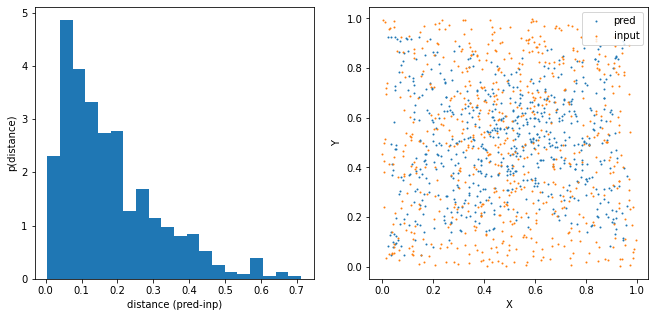

In [19]:
Xinp = t[1][:,0::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0]
Yinp = t[1][:,1::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0]
Xpred = x_hat[:,0::3].view(-1,x_hat.size()[0]*x_hat.size()[1]//3)[0]
Ypred = x_hat[:,1::3].view(-1,x_hat.size()[0]*x_hat.size()[1]//3)[0]
dist = torch.sqrt((Xinp-Xpred)**2+(Yinp-Ypred)**2).tolist()
print('Average deviation is {0:7.2f}%'.format(100*np.mean(dist)))

fig, ax = plt.subplots(1,2,figsize=(11,5))

ax[0].hist(dist,density=True,bins=20)
ax[0].set_xlabel('distance (pred-inp)')
ax[0].set_ylabel('p(distance)')

ax[1].scatter(Xpred,Ypred,label='pred',s=1)
ax[1].scatter(Xinp,Yinp,label='input',s=1)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].legend()

plt.show()

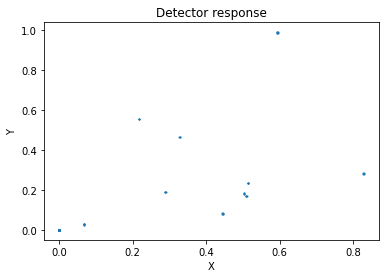

In [18]:
gt = t[0][0]
plt.scatter([gt[2*i] for i in range(len(gt)//2)],[gt[2*i+1] for i in range(len(gt)//2)],s=1)
plt.title('Detector response')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [20]:
print('input ground truth: ',t[1][0][::3])
print('prediction:         ',x_hat[0][::3])

input ground truth:  tensor([0.0672, 0.2157, 0.2882, 0.3275, 0.4459, 0.5031, 0.5100, 0.5133, 0.5928,
        0.8284])
prediction:          tensor([0.0858, 0.1730, 0.2490, 0.3232, 0.3782, 0.4392, 0.4947, 0.5517, 0.6518,
        0.7977])


## k-means method

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn

X = t[0][0].cpu().detach().numpy().reshape((-1,2))
zs = np.where(X == 0)[0]
if(len(zs) > 0):
    X = X[0:(zs[0])]


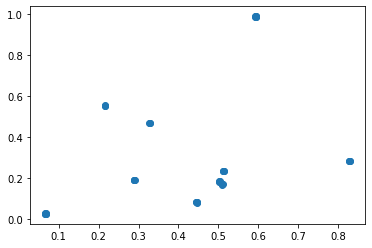

In [22]:
plt.scatter(X[:,0], X[:,1])

In [23]:
import pandas as pd

df = pd.DataFrame(columns=['n','inertia','bic','aic','silhouette','davies','homogeneity','completeness','vmeasure','calinski'],dtype=float)

for i in range(2, 16):
    y = np.zeros(len(X))
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    y_pred = kmeans.predict(X)
    gmm = GaussianMixture(n_components=i, init_params='kmeans')
    gmm.fit(X)
    bic, aic = gmm.bic(X), gmm.aic(X)
    sil = silhouette_score(X, y_pred)
    db = davies_bouldin_score(X, y_pred)
    hom = homogeneity_score(y, y_pred)
    com = completeness_score(y, y_pred)
    vms = v_measure_score(y, y_pred)
    cal = calinski_harabasz_score(X, y_pred)
    
    df.loc[i] = [i,kmeans.inertia_,bic,aic,sil,db,hom,com,vms,cal]


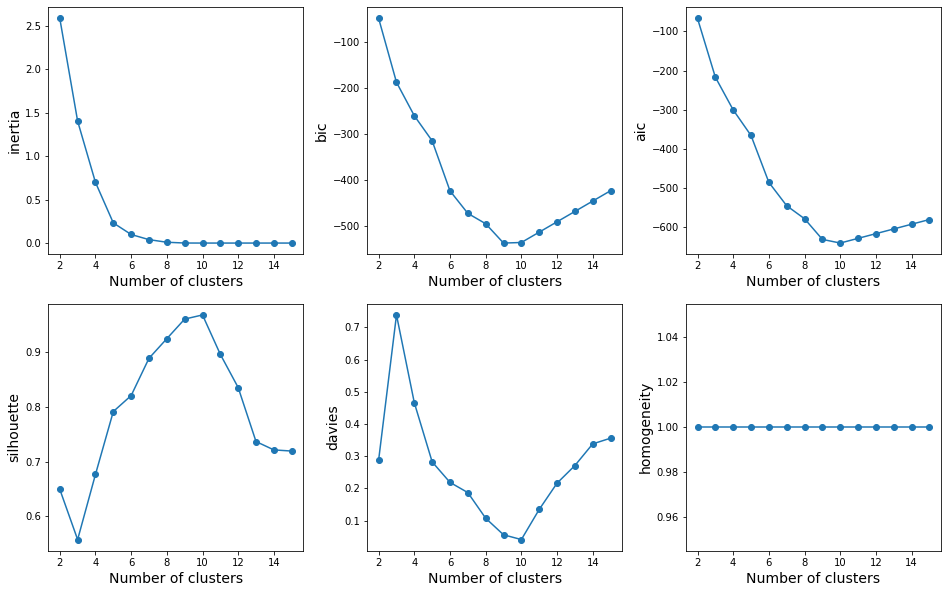

In [24]:
fig, axs = plt.subplots(2,3,figsize=(16,10))
plt.subplots_adjust(wspace=0.25)

for i, ax in enumerate(fig.axes):
    ax.scatter(df['n'],df.iloc[:,(i+1)])
    ax.plot(df['n'],df.iloc[:,(i+1)])
    ax.set_xlabel('Number of clusters',fontsize=14)
    ax.set_ylabel(df.columns[i+1],fontsize=14)
plt.show()

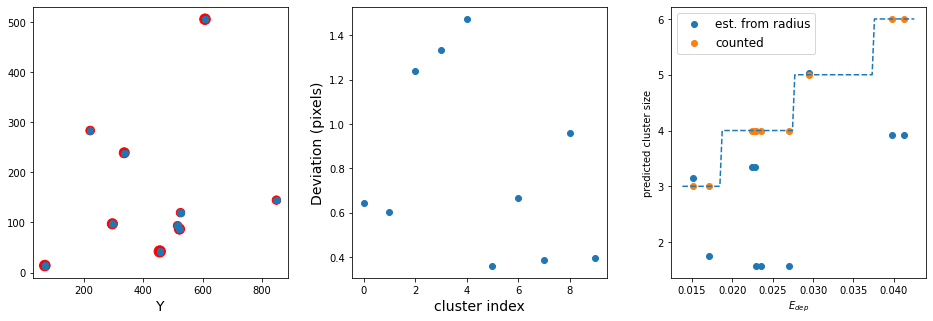

In [26]:
from scipy.spatial.distance import cdist

# select min BIC cluster size
ns = int(df.iloc[np.argmin(df.iloc[:,2]),0])
ns=10

kmeans = KMeans(n_clusters=ns, init='k-means++', max_iter=300, n_init=10, random_state=0)
Xr = X.copy()
Xr[:,0] *= 1024
Xr[:,1] *= 512
pred_y = kmeans.fit_predict(Xr)

km = kmeans.cluster_centers_.copy()
# sorting index: increasing values first in X, second in Y
ikm1 = np.argsort(km[:,1])
ikm = np.argsort(km[ikm1][:,0])
ikm = ikm1[ikm]

# calculate radii of clusters
labels = kmeans.fit(Xr).predict(Xr)
radii = [cdist(Xr[labels == i], [center]).max() for i, center in enumerate(km)]

fig, ax = plt.subplots(1,3,figsize=(16,5))
plt.subplots_adjust(wspace=0.25)

ax[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=[100*r for r in radii], c='red')
ax[0].scatter(Xr[:,0], Xr[:,1])
ax[0].set_xlabel('X', fontsize=14)
ax[0].set_xlabel('Y', fontsize=14)

km = km[np.argsort(km[:,1])]
km = km[np.argsort(km[:,0])]
Xp = 1024*t[1][0][0::3]-km[:,0]
Yp =  512*t[1][0][1::3]-km[:,1]
Dp = np.sqrt(Xp*Xp+Yp*Yp)

#ax[1].scatter(range(10),100*(t[1][0][0::3]-km[:,0])/t[1][0][0::3], label='X')
#ax[1].scatter(range(10),100*(t[1][0][1::3]-km[:,1])/t[1][0][1::3], label='Y')
ax[1].scatter(range(10), Dp)
ax[1].set_xlabel('cluster index', fontsize=14)
ax[1].set_ylabel('Deviation (pixels)', fontsize=14)
#ax[1].set_ylabel('Deviation (%)', fontsize=14)
#ax[1].legend(fontsize=12)

ax[2].scatter(t[1][0][2::3], [np.pi*radii[i]**2  for i in ikm], label='est. from radius')
ax[2].scatter(t[1][0][2::3], [len(labels[labels==i]) for i in ikm], label='counted')
tx = np.linspace(max(ax[2].get_xlim()[0],0.),ax[2].get_xlim()[1],100)
ty = np.floor(4.2267 * (tx*40.)**0.65 + 0.5)
ax[2].plot(tx,ty,ls='dashed')
ax[2].set_xlabel(r'$E_{dep}$')
ax[2].set_ylabel('predicted cluster size')
ax[2].legend(fontsize=12)

plt.show()

In [27]:
print(t[1][0])
print(t[0][0])

tensor([0.0672, 0.0263, 0.0398, 0.2157, 0.5542, 0.0172, 0.2882, 0.1917, 0.0228,
        0.3275, 0.4691, 0.0151, 0.4459, 0.0804, 0.0294, 0.5031, 0.1825, 0.0229,
        0.5100, 0.1706, 0.0224, 0.5133, 0.2327, 0.0236, 0.5928, 0.9877, 0.0412,
        0.8284, 0.2828, 0.0270])
tensor([0.0664, 0.0254, 0.0664, 0.0273, 0.0664, 0.0293, 0.0674, 0.0254, 0.0674,
        0.0273, 0.0674, 0.0293, 0.2158, 0.5527, 0.2158, 0.5547, 0.2168, 0.5527,
        0.2881, 0.1895, 0.2891, 0.1895, 0.2891, 0.1914, 0.2900, 0.1895, 0.3271,
        0.4668, 0.3281, 0.4668, 0.3291, 0.4668, 0.4443, 0.0820, 0.4443, 0.0840,
        0.4453, 0.0801, 0.4453, 0.0820, 0.4453, 0.0840, 0.5029, 0.1816, 0.5029,
        0.1836, 0.5039, 0.1816, 0.5039, 0.1836, 0.5088, 0.1699, 0.5098, 0.1680,
        0.5098, 0.1699, 0.5107, 0.1699, 0.5127, 0.2324, 0.5127, 0.2344, 0.5137,
        0.2324, 0.5137, 0.2344, 0.5928, 0.9863, 0.5928, 0.9883, 0.5938, 0.9863,
        0.5938, 0.9883, 0.5947, 0.9863, 0.5947, 0.9883, 0.8281, 0.2812, 0.8281,
       

In [47]:
im = -1; jm =-1; md = 10.
for i in np.arange(9):
    for j in np.arange(i+1,10):
        d=cdist([[t[1][0][0::3][i],t[1][0][1::3][i]]],[[t[1][0][0::3][j],t[1][0][1::3][j]]])[0][0]
        if(d < md):
            md = d; im=i; jm=j
print('Minimum distance is between {0} and {1} being {2:.3f}: ({3:.3f},{4:.3f}) - ({5:.3f},{6:.3f})'.format(im,jm,md,
        t[1][0][0::3][im],t[1][0][1::3][im],t[1][0][0::3][jm],t[1][0][1::3][jm]))


Minimum distance is between 5 and 6 being 0.014: (0.503,0.182) - (0.510,0.171)
